In [1]:
# Read the numerical model output, make some maps to check the conditions, crop the fields of interest in the areas
# of interest and save them in a netcdf file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geometry as gm

In [2]:
# To plot maps.
crs = ccrs.PlateCarree()

def plot_background(ax):
    #ax.set_extent(extent_param)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    #ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 14}
    gl.ylabel_style = {'fontsize': 14}
    return ax

In [3]:
def crop_field(field,lon,lat,area):
    """
    Function to crop a 2d field over the area specified by the list
    area = [minlon,minlat,maxlon,maxlat]
    """
    valid_indices = np.argwhere((lon>area[0])&(lon<area[2])&(lat>area[1])&(lat<area[3]))
    x_min, y_min = valid_indices.min(axis=0)
    x_max, y_max = valid_indices.max(axis=0)
    return field[x_min:x_max+1, y_min:y_max+1]

In [4]:
# Set the paths and the file names of the (coupled) oceanic and atmospheric model outputs.
experiment = 'CTRL' # Choose between 'CTRL' and 'NOCRT'
path2atm = '/home/agostino/hrmn_numerical_model_scenes_some_data/med_renault_etal_2021/'+experiment+'/'

In [51]:
# Set the instant of interest.
str_instant = '2005-01-01T12:00:00'
# Valid range: from 2005-01-01_12:00:00 to 2005-01-31_12:00:00, one file per day, at 12:00:00 only.

filename = path2atm + 'wrfout_Y' + str_instant[:4] + 'M' + str_instant[5:7]+'.nc'
print(filename)

/home/agostino/hrmn_numerical_model_scenes_some_data/med_renault_etal_2021/CTRL/wrfout_Y2005M01.nc


In [52]:
# Read the file.
ds = xr.open_dataset(filename)
ds

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, lev_M: 39, lev_W: 40, time_counter: 31, x_grid_M: 191, x_grid_U: 192, x_grid_V: 191, y_grid_M: 215, y_grid_U: 215, y_grid_V: 216)
Coordinates:
    nav_lat_grid_U        (y_grid_U, x_grid_U) float32 ...
    nav_lon_grid_U        (y_grid_U, x_grid_U) float32 ...
  * lev_M                 (lev_M) float32 1.0 2.0 3.0 4.0 ... 37.0 38.0 39.0
    nav_lat_grid_V        (y_grid_V, x_grid_V) float32 ...
    nav_lon_grid_V        (y_grid_V, x_grid_V) float32 ...
    nav_lat_grid_M        (y_grid_M, x_grid_M) float32 ...
    nav_lon_grid_M        (y_grid_M, x_grid_M) float32 ...
  * lev_W                 (lev_W) float32 1.0 2.0 3.0 4.0 ... 38.0 39.0 40.0
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2005-01-01T12:00:00 ....
Dimensions without coordinates: axis_nbounds, x_grid_M, x_grid_U, x_grid_V, y_grid_M, y_grid_U, y_grid_V
Data variables: (12/51)
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    U                     (time_counter, lev_M, y_grid_U, x_grid_U) float32 ...
    V                     (time_counter, lev_M, y_grid_V, x_grid_V) float32 ...
    W                     (time_counter, lev_W, y_grid_M, x_grid_M) float32 ...
    PH                    (time_counter, lev_W, y_grid_M, x_grid_M) float32 ...
    ...                    ...
    RHOL1                 (time_counter, y_grid_M, x_grid_M) float32 ...
    U_PHYL1               (time_counter, y_grid_M, x_grid_M) float32 ...
    V_PHYL1               (time_counter, y_grid_M, x_grid_M) float32 ...
    TAUX                  (time_counter, y_grid_M, x_grid_M) float32 ...
    TAUY                  (time_counter, y_grid_M, x_grid_M) float32 ...
    TAUM                  (time_counter, y_grid_M, x_grid_M) float32 ...
Attributes: (12/88)
    name:                            wrfout_Y2005M01
    description:                     wrf M grid variables
    title:                           wrf M grid variables
    Conventions:                     CF-1.6
    timeStamp:                       2020-May-06 18:00:31 GMT
    uuid:                            a9d09423-a881-4cff-9e45-74032a3b61ee
    ...                              ...
    NUM_LAND_CAT:                    24
    ISWATER:                         16
    ISLAKE:                          -1
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14

In [53]:
instant = np.datetime64(str_instant)

# Read the fields of interest.

lon = ds['nav_lon_grid_M'].values
lat = ds['nav_lat_grid_M'].values
u10 = ds['U10'].sel(time_counter=instant).values
v10 = ds['V10'].sel(time_counter=instant).values
sst = ds['SST'].sel(time_counter=instant).values
uc = ds['UOCE'].sel(time_counter=instant).values
vc = ds['VOCE'].sel(time_counter=instant).values

seamask_nan = (uc**2+vc**2)/(uc**2+vc**2)

# Create a dataset.
ds = xr.Dataset(
    data_vars = dict(
        lon=(["x","y"],lon),    
        lat=(["x","y"],lat),    
        uc=(["x","y"],uc*seamask_nan,dict(units='m/s')),    
        vc=(["x","y"],vc*seamask_nan,dict(units='m/s')),    
        sst=(["x","y"],sst*seamask_nan,dict(units='K')),    
        u10=(["x","y"],u10*seamask_nan,dict(units='m/s')),    
        v10=(["x","y"],v10*seamask_nan,dict(units='m/s'))    
    ),
    attrs=dict(
        ref_time = str_instant
    )
)

# Save the netcdf.
strfile = 'western_med_'+experiment+'_'+str_instant+'.nc'
ds.to_netcdf(strfile)

<ipython-input-53-5872e0d0eb95>:13: RuntimeWarning: invalid value encountered in true_divide
  seamask_nan = (uc**2+vc**2)/(uc**2+vc**2)


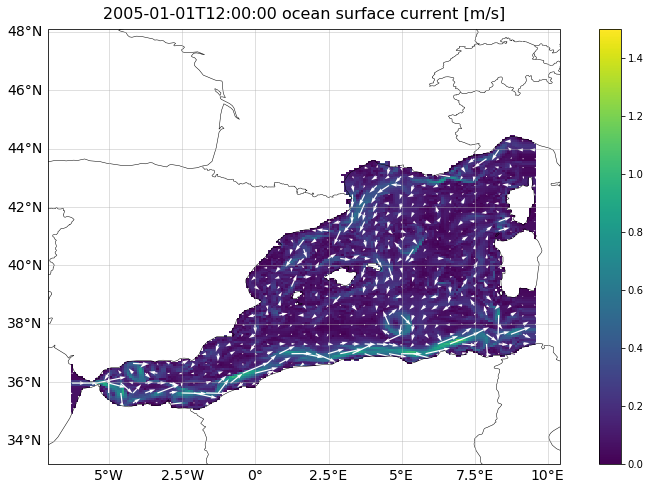

In [54]:
# Plot some maps.

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1, 1, 1, projection=crs)
plot_background(ax)
pc = plt.pcolormesh(lon,lat,np.sqrt(uc**2+vc**2)*seamask_nan,vmin=0,vmax=1.5)
step = 5
qv = plt.quiver(lon[::step,::step],lat[::step,::step],uc[::step,::step]*seamask_nan[::step,::step],
                vc[::step,::step]*seamask_nan[::step,::step],color='w',scale=15)

plt.title(str_instant + ' ocean surface current [m/s]', fontsize=16)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.colorbar(pc)

figure_name = 'western_med_'+experiment+'_'+str_instant+'_ocean_surface_currents.png'
plt.savefig(figure_name,bbox_inches='tight') 

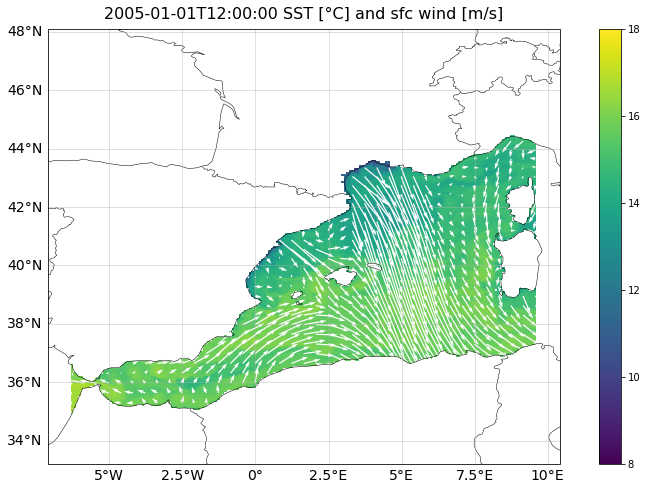

In [55]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1, 1, 1, projection=crs)
plot_background(ax)
pc = plt.pcolormesh(lon,lat,(sst-273.15)*seamask_nan,vmin=8,vmax=18)
step = 5
qv = plt.quiver(lon[::step,::step],lat[::step,::step],u10[::step,::step]*seamask_nan[::step,::step],
                v10[::step,::step]*seamask_nan[::step,::step],color='w',scale=150)
#ct = plt.contour(lon_c,lat_c,np.sqrt(u10_c**2+v10_c**2),colors='r')
plt.title(str_instant + ' SST [°C] and sfc wind [m/s]', fontsize=16)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.colorbar(pc)
figure_name = 'western_med_'+experiment+'_'+str_instant+'_sst_and_sfc_wind.png'
plt.savefig(figure_name,bbox_inches='tight') 